# Analysis of Workload Experimental Data with YCSB: Impact of Varying Value Sizes - TPCTC 2025

We investigated database performance under varying value sizes using an enhanced version of YCSB, named [YCSB-IVS](https://github.com/dliyanage/YCSB-IVS) (YCSB - Increasing Value Sizes).

Our benchmarking approach introduces a novel technique applied to three widely-used databases: 

- **MariaDB + RocksDB**
- **MariaDB + InnoDB**
- **MongoDB**

### Repository Structure
The experimental data, analysis scripts, and output figures referenced in our conference paper are organized as follows:
- **`./Data`**: Raw experimental data.
- **`./Scripts`**: Analysis scripts (Jupyter notebooks in R).
- **`./Figures`**: Generated output figures.
- **`./Technical Report`**: Copy of the technical report containing all the experimental results.

### Analysis Workflow
The R notebook in the `./Scripts` folder contains:
- A step-by-step explanation of the analysis process.
- All generated figures, alongside intermediate and final outputs.


In [1]:
# Required Libraries
library(ggplot2)
library(tidyverse)
library(zoo)
library(gridExtra)
library(patchwork)
library(wesanderson)
library(stringr)
library(viridis)
library(viridis)
library(forcats)
library(cowplot)
library(scales)
library(patchwork)

# Supress warnings for clear visibility of the notebook
options(warn=-1)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required pack

### Performance Evaluation of Read-Only Workloads: Lightweight vs. Heavyweight

In [3]:
# Setting working directory
if (!exists("analysis_directory")) {
    script_directory <- getwd()
    analysis_directory <- dirname(script_directory)
}
setwd(paste(analysis_directory, "/Data/Workload_data/Workload-C(READ-ONLY)/", sep = ""))

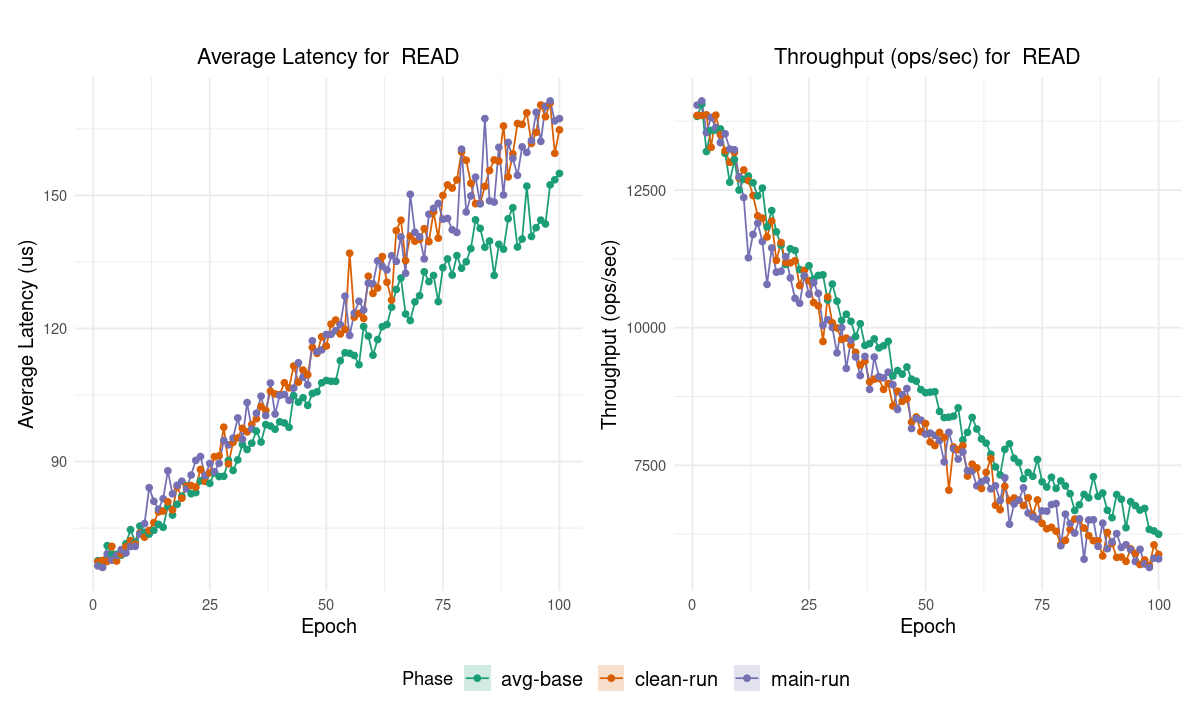

In [4]:
# Define repeat_non_zero helper function at the top
repeat_non_zero = function(column) {
  n = length(column)
  status = rep(0, n)
  for (i in 1:n) {
    if (column[i] != 0 && status[i] == 0) {
      if (i + 1 <= n && column[i + 1] == 0 && status[i + 1] == 0) {
        column[i + 1] = column[i]
        status[i + 1] = 1
      }
      if (i + 2 <= n && column[i + 2] == 0 && status[i + 2] == 0) {
        column[i + 2] = column[i]
        status[i + 2] = 1
      }
    }
  }
  return(column)
}

# Different variations of databases, request distributions, and workload weights
databases = c("innodb", "rocksdb", "mongodb")
runs = c("run1", "run2","run3","run4","run5")
distributions = c("uniform", "zipfian")
loads = c("light", "heavy")

# Workload operation under consideration
operation = "READ"
workload_identifier = "C"

# Loop over configurations
for (database in databases) {
  for (dist in distributions) {
    for (load in loads) {

      combined_data = data.frame()

      for (run in runs) {
        file = paste0(database, "_", run, "_", dist, "_", load, ".csv")

        if (file.exists(file)) {
          data = read.csv(file)

          data = data %>% 
            mutate(Phase = ifelse(Phase == "run", "main-run", 
                                  ifelse(Phase == "avg-run", "avg-base", Phase))) %>%
            filter(Phase != "reference") %>%
            select(-Insertprop) %>%
            mutate(Extendprop = repeat_non_zero(Extendprop)) %>%
            mutate(Run = run) # tag run source

          combined_data = bind_rows(combined_data, data)
        }
      }

      if (nrow(combined_data) == 0) {
        next  # Skip if no files found for this combination
      }

      # Compute means and 95% confidence intervals
      data_avg = combined_data %>%
        filter(Operation == operation) %>%
        group_by(Epoch, Phase) %>%
        summarise(
          Latency_mean = mean(AverageLatency.us., na.rm = TRUE),
          Latency_se = sd(AverageLatency.us., na.rm = TRUE) / sqrt(n()),
          Latency_lower = Latency_mean - Latency_se,
          Latency_upper = Latency_mean + Latency_se,

          TP_mean = mean(Throughput.ops.sec., na.rm = TRUE),
          TP_se = sd(Throughput.ops.sec., na.rm = TRUE) / sqrt(n()),
          TP_lower = TP_mean - TP_se,
          TP_upper = TP_mean + TP_se,
          .groups = 'drop'
        )

      # Plot Latency
      latency_plot = ggplot(data_avg, aes(x = Epoch, y = Latency_mean, color = Phase, fill = Phase)) +
        geom_line() +
        geom_point() +
        geom_ribbon(aes(ymin = Latency_lower, ymax = Latency_upper), alpha = 0.2, color = NA) +
        scale_y_continuous(name = "Average Latency (us)") +
        labs(title = paste("Average Latency for ", operation), x = "Epoch") +
        theme_minimal() +
        theme(
          plot.title = element_text(hjust = 0.5, size = 13),
          axis.title = element_text(size = 12),
          legend.text = element_text(size = 12)
        ) +
        scale_color_brewer(palette = "Dark2") +
        scale_fill_brewer(palette = "Dark2")

      # Plot Throughput
      throughput_plot = ggplot(data_avg, aes(x = Epoch, y = TP_mean, color = Phase, fill = Phase)) +
        geom_line() +
        geom_point() +
        geom_ribbon(aes(ymin = TP_lower, ymax = TP_upper), alpha = 0.2, color = NA) +
        scale_y_continuous(name = "Throughput (ops/sec)") +
        labs(title = paste("Throughput (ops/sec) for ", operation), x = "Epoch") +
        theme_minimal() +
        theme(
          plot.title = element_text(hjust = 0.5, size = 13),
          axis.title = element_text(size = 12),
          legend.text = element_text(size = 12)
        ) +
        scale_color_brewer(palette = "Dark2") +
        scale_fill_brewer(palette = "Dark2")

      # Combine plots
      combined_plot = (latency_plot | throughput_plot) +
        plot_layout(guides = "collect") +
        plot_annotation(title = "") &
        theme(legend.position = "bottom")

      # Save to PDF
      plot_file = paste0(database, "_", dist, "_", load, "_", workload_identifier, ".pdf")
      pdf(paste0(analysis_directory, "/Figures/", database, "/", plot_file), width = 10, height = 6)
      print(combined_plot)
      dev.off()
    }
  }
}

# Optionally show the last plot inline if running interactively
options(repr.plot.width = 10, repr.plot.height = 6)
print(combined_plot)

### Justification for Using Average Latency as a Representative Measure

pdf 
  2

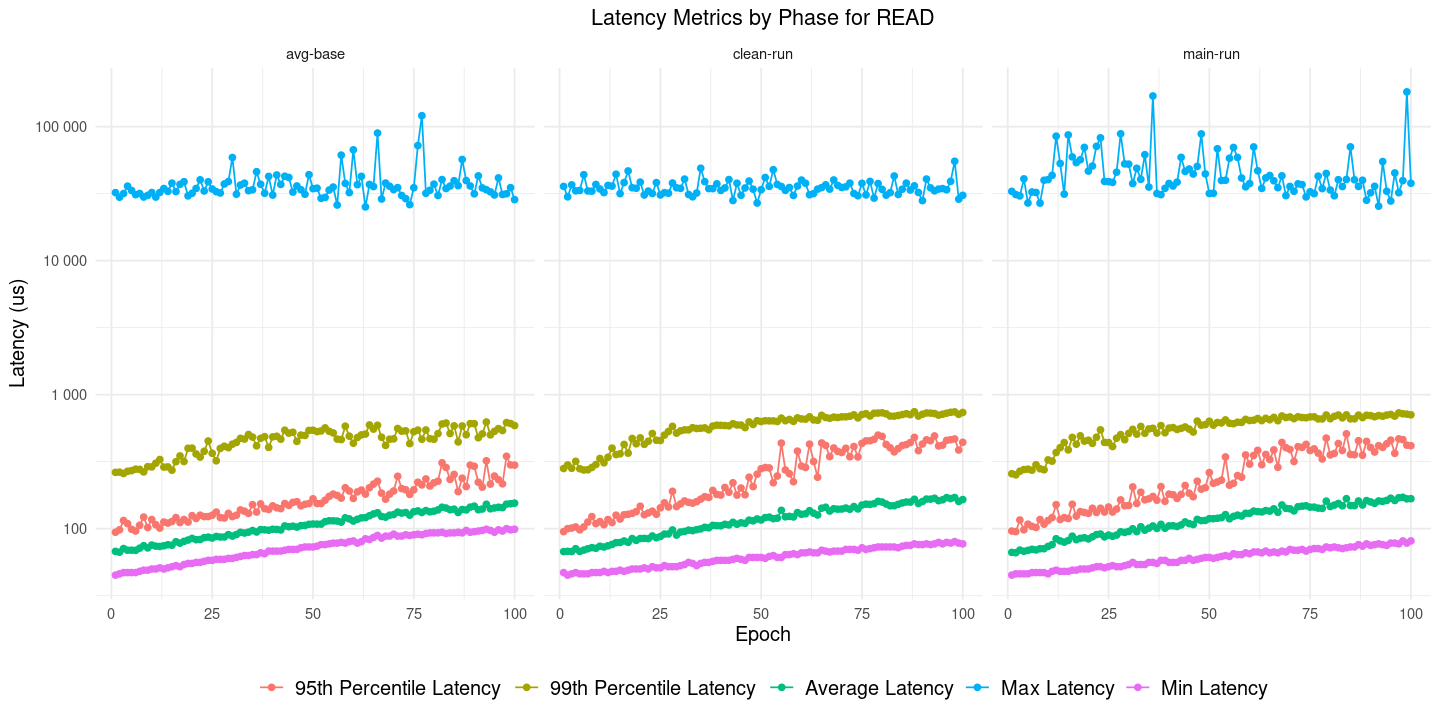

In [5]:
# Latency distribution comparison by Phase for multiple metrics
phase_wise_latency = ggplot(data = data %>% filter(Phase != "extend"), aes(x = Epoch)) +
  geom_line(aes(y = AverageLatency.us., color = "Average Latency")) +
  geom_point(aes(y = AverageLatency.us., color = "Average Latency")) +
  
  geom_line(aes(y = MinLatency.us., color = "Min Latency")) +
  geom_point(aes(y = MinLatency.us., color = "Min Latency")) +
  
  geom_line(aes(y = MaxLatency.us., color = "Max Latency")) +
  geom_point(aes(y = MaxLatency.us., color = "Max Latency")) +
  
  geom_line(aes(y = X95thPercentileLatency.us., color = "95th Percentile Latency")) +
  geom_point(aes(y = X95thPercentileLatency.us., color = "95th Percentile Latency")) +
  
  geom_line(aes(y = X99thPercentileLatency.us., color = "99th Percentile Latency")) +
  geom_point(aes(y = X99thPercentileLatency.us., color = "99th Percentile Latency")) +
  
  scale_y_log10(name = "Latency (us)", labels = label_number()) +
  labs(
    title = paste("Latency Metrics by Phase for", operation),
    x = "Epoch"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 13),
    legend.title = element_blank(),
    legend.position = "bottom",
    axis.title = element_text(size = 12),
    legend.text = element_text(size = 12)
  ) +
  facet_wrap(~ Phase, ncol = 4) 

# Set PDF device with specified width and height
plot_name = paste(database,"_","latency_measures.pdf", sep = "")
pdf(paste(analysis_directory, "/Figures/", database, "/", plot_name, sep = ""), width = 12, height = 6) 

# Print the plot object
print(phase_wise_latency)

# Turn off the PDF device
dev.off()

# Show saved plot
options(repr.plot.width=12, repr.plot.height=6)
print(phase_wise_latency)


### Performance Evaluation of Workload A (50:50 READ:UPDATE) for Heavyweight

In [6]:
# Changing working directory
setwd(paste(analysis_directory, "/Data/Workload_data/Workload-A(READ-UPDATE)/", sep = ""))

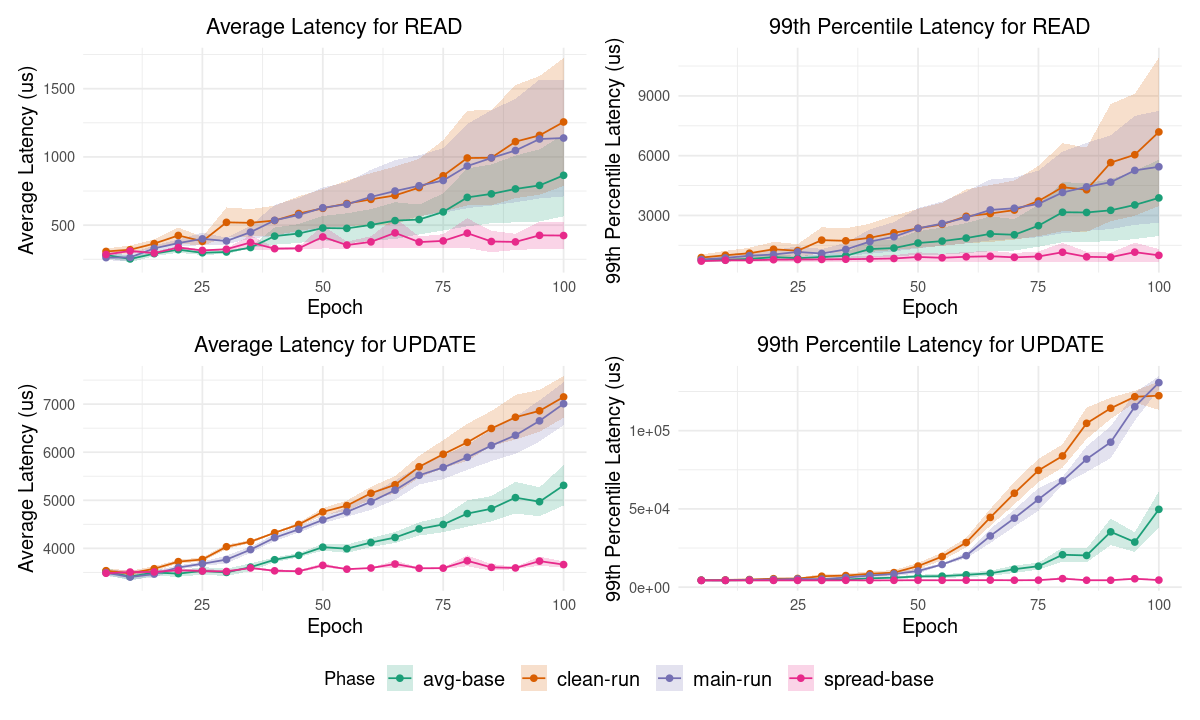

In [7]:
databases = c("innodb", "mongodb", "rocksdb")
request_dist = c("uniform", "zipfian")
scale = "heavy"
workload = "a"
workload_identifier = paste0("workload", workload)

for (database in databases) {
  for (dist in request_dist) {
    
    data = tibble()
    run = 1
    
    repeat {
      temp_path = paste0(database, "_", scale, "_", dist, "_", workload_identifier, "_", run, ".csv")
      spread_path = paste0(database, "_", scale, "_", dist, "_", workload_identifier, "_", run, "_spread.csv")
      
      file_exists = FALSE
      
      if (file.exists(temp_path)) {
        temp = read.csv(temp_path)
        temp$trial = run
        data = rbind(data, temp)
        file_exists = TRUE
      }
      
      if (file.exists(spread_path)) {
        spread = read.csv(spread_path)
        spread$trial = run
        data = rbind(data, spread)
        file_exists = TRUE
      }
      
      if (!file_exists) break
      run = run + 1
    }
    
    if (nrow(data) == 0) next
    
    # Clean and preprocess data
    data = data %>% 
      mutate(Phase = ifelse(Phase == "run", "main-run", 
                            ifelse(Phase == "avg-run", "avg-base",
                                   ifelse(Phase == "spread-run", "spread-base", Phase)))) %>%
      filter(Phase != "reference")
    
    repeat_non_zero = function(column) {
      n = length(column)
      status = rep(0,n)
      for (i in 1:n) {
        if (column[i] != 0 && status[i] == 0) {
          if (i + 1 <= n && column[i + 1] == 0 && status[i + 1] == 0) {
            column[i + 1] = column[i]
            status[i + 1] = 1
          }
          if (i + 2 <= n && column[i + 2] == 0 && status[i + 2] == 0) {
            column[i + 2] = column[i]
            status[i + 2] = 1
          }
        }
      }
      return(column)
    }
    
    data = data %>%
      select(-Insertprop) %>%
      mutate(Extendprop = repeat_non_zero(Extendprop))
    
    latency_metrics = c("AverageLatency.us.", "X99thPercentileLatency.us.")
    metric_labels = c(
      "AverageLatency.us." = "Average Latency",
      "X99thPercentileLatency.us." = "99th Percentile Latency"
    )
    
    all_plots = list()
    operations = setdiff(unique(data$Operation), "EXTEND")
    
    # Throughput plot
    throughput_data = data %>%
      filter(!is.nan(Throughput.ops.sec.) & Operation == "READ")
    
    summary_throughput = throughput_data %>%
      group_by(Epoch, Phase) %>%
      summarise(
        mean_throughput = mean(Throughput.ops.sec., na.rm = TRUE),
        se_throughput   = sd(Throughput.ops.sec., na.rm = TRUE) / sqrt(n()),
        .groups = "drop"
      ) %>%
      mutate(
        ci_lower = mean_throughput - se_throughput,
        ci_upper = mean_throughput + se_throughput
      )
    
    p_throughput = ggplot(summary_throughput, aes(x = Epoch * 5, y = mean_throughput, color = Phase, fill = Phase)) +
      geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper), alpha = 0.2, color = NA) +
      geom_line() +
      geom_point() +
      scale_y_continuous(name = "Average Throughput (ops/sec)") +
      labs(title = "Average Throughput", x = "Epoch") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5, size = 13),
            axis.title = element_text(size = 12),
            legend.text = element_text(size = 12)) +
      scale_color_brewer(palette = "Dark2") +
      scale_fill_brewer(palette = "Dark2")
    
    all_plots[["throughput"]] = p_throughput
    
    # Latency plots
    for (op in operations) {
      data_op = data %>% filter(Operation == op)
      for (metric in latency_metrics) {
        summary_data = data_op %>%
          group_by(Epoch, Phase) %>%
          summarise(
            mean_metric = mean(.data[[metric]], na.rm = TRUE),
            se_metric   = sd(.data[[metric]], na.rm = TRUE) / sqrt(n()),
            .groups = "drop"
          ) %>%
          mutate(
            ci_lower = mean_metric - se_metric,
            ci_upper = mean_metric + se_metric
          )
        
        metric_label = paste0(metric_labels[[metric]], " (us)")
        
        p = ggplot(summary_data, aes(x = Epoch * 5, y = mean_metric, color = Phase, fill = Phase)) +
          geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper), alpha = 0.2, color = NA) +
          geom_line() +
          geom_point() +
          scale_y_continuous(name = metric_label) +
          labs(title = paste(metric_labels[[metric]], "for", op), x = "Epoch") +
          theme_minimal() +
          theme(plot.title = element_text(hjust = 0.5, size = 13),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12)) +
          scale_color_brewer(palette = "Dark2") +
          scale_fill_brewer(palette = "Dark2")
        
        all_plots[[paste0(op, "_", metric)]] = p
      }
    }
    
    # Save latency plots
    latency_plots = all_plots[names(all_plots) != "throughput"]
    latency_final_plot = wrap_plots(latency_plots, ncol = 2) +
      plot_layout(guides = "collect") &
      theme(legend.position = "bottom")

    latency_pdf = paste0(analysis_directory, "/Figures/", database, "/", database, "_", scale, "_", dist, "_latency_", toupper(workload), ".pdf")
    pdf(latency_pdf, width = 12, height = 8)
    print(latency_final_plot)
    dev.off()

    # Save throughput plot
    throughput_plot = all_plots[["throughput"]] + theme(legend.position = "bottom")
    throughput_pdf = paste0(analysis_directory, "/Figures/", database, "/", database, "_", scale, "_", dist, "_throughput_", toupper(workload), ".pdf")
    pdf(throughput_pdf, width = 6, height = 4)
    print(throughput_plot)
    dev.off()
  
  }
}

# Optionally show the last plot inline if running interactively
options(repr.plot.width = 10, repr.plot.height = 6)
print(latency_final_plot)


### Value Extension Costs for Each Database and Data Load Combination

pdf 
  2

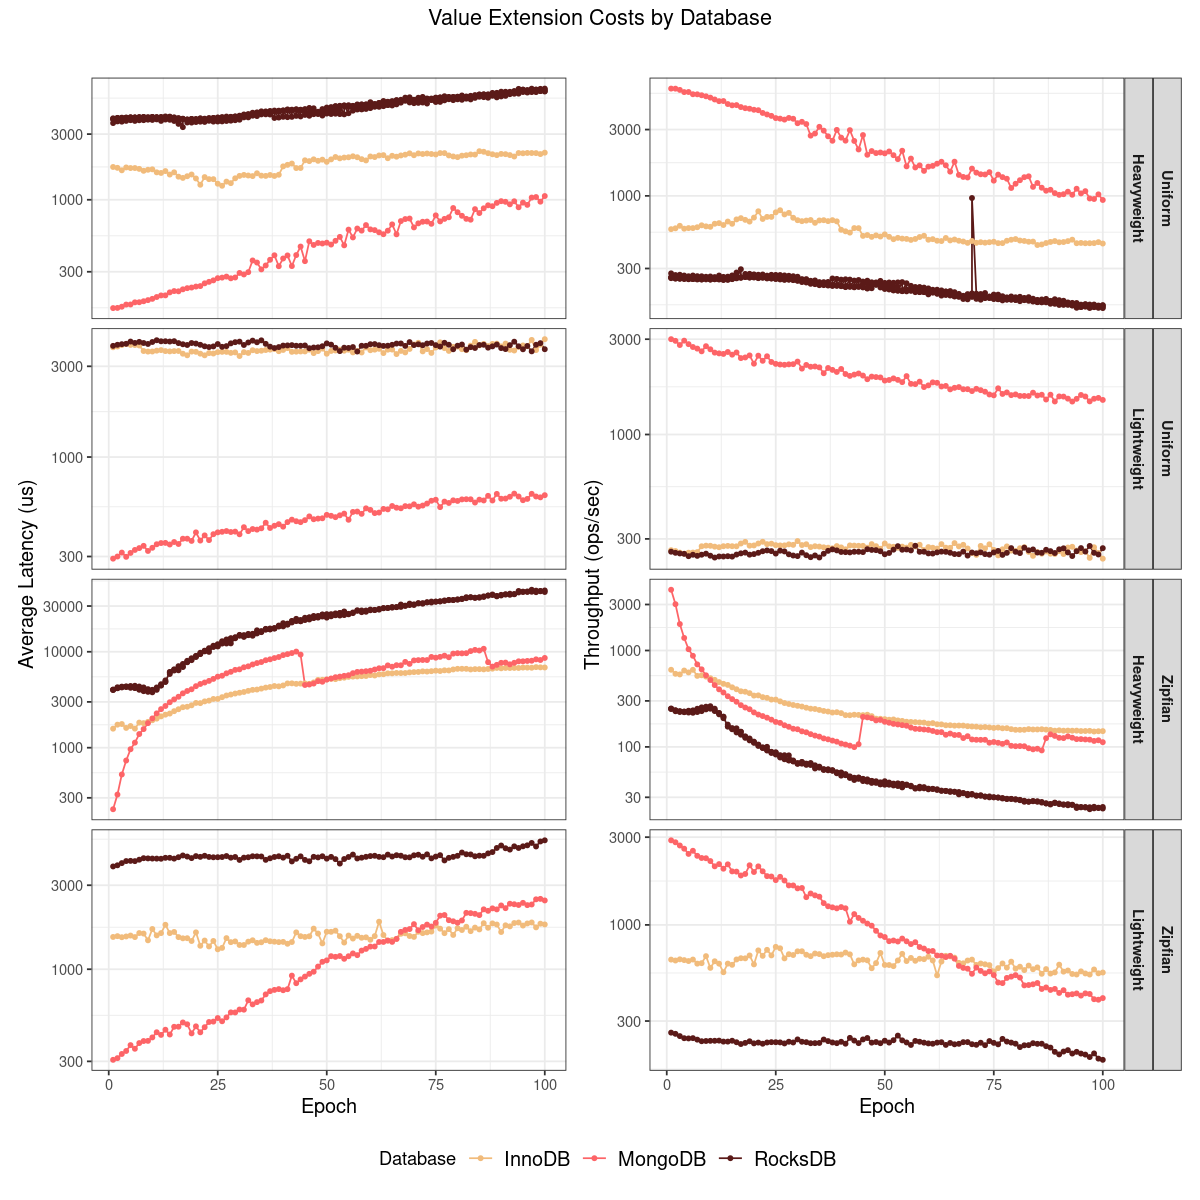

In [9]:
#Change working directory
setwd(paste(analysis_directory, "/Data/Workload_data/Workload-C(READ-ONLY)/", sep = ""))

## Analyse cost for extensions

# Define the variables to keep from each CSV file
variables_to_keep = c("Epoch", "Phase", "Recordcount", "Readallfields", "Requestdist", "Operation", 
                       "Readprop", "Updateprop", "Scanprop", "Insertprop", "Extendprop", 
                       "Runtime.ms.", "Throughput.ops.sec.", "Operations", "AverageLatency.us.", 
                       "MinLatency.us.", "MaxLatency.us.", "X95thPercentileLatency.us.", "X99thPercentileLatency.us.")


# Generate file names
file_combinations = expand.grid(database = databases, run = runs, dist = distributions, load = loads)
file_names = paste0(file_combinations$database, "_", file_combinations$run, "_", 
                     file_combinations$dist, "_", file_combinations$load, ".csv")

# Initialize an empty list to store data frames
data_list = list()

# Loop through files and read data
for (i in seq_along(file_names)) {
  file_path = file_names[i]
  
  # Check if the file exists
  if (file.exists(file_path)) {
    # Read the CSV file
    df = read.csv(file_path, stringsAsFactors = FALSE)
    
    # Filter the selected variables
    df = df %>% select(all_of(variables_to_keep))  # Select only the required columns
    
    # Add metadata columns to the data frame
    df$database = file_combinations$database[i]
    df$run = file_combinations$run[i]
    df$dist = file_combinations$dist[i]
    df$load = file_combinations$load[i]
    
    # Append the data frame to the list
    data_list[[file_path]] = df
  } else {
    warning(paste("File not found:", file_path))
  }
}

# Combine all data frames into a single data frame
data = do.call(rbind, data_list)
row.names(data) = NULL

data = data %>% 
  mutate(Phase = ifelse(Phase == "run", "main-run", 
                        ifelse(Phase == "avg-run", "avg-base",
                               ifelse(Phase == "spread-run", "spread-base",Phase)))) %>%
  filter(Phase != "reference")


# Replace 0 values with non-zero value correspond to the experiment
repeat_non_zero = function(column) {
  n = length(column)
  status = rep(0,n)
  for (i in 1:n) {
    if (column[i] != 0 && status[i] == 0) {
      if (i + 1 <= n && column[i + 1] == 0 && status[i + 1] == 0) {
        column[i + 1] = column[i]
        status[i + 1] = 1
      }
      if (i + 2 <= n && column[i + 2] == 0 && status[i + 2] == 0) {
        column[i + 2] = column[i]
        status[i + 2] = 1
      }
    }
  }
  return(column)
}


data = data %>%
  mutate(Extendprop = repeat_non_zero(Extendprop))

# Filter data for extends
operation = "EXTEND" # Update operation variable

# Re-word the labels
data_op = data %>% filter(Operation==operation) %>%
  mutate(load = ifelse(load == "heavy", "Heavyweight", "Lightweight")) %>%
  mutate(dist = ifelse(dist == "uniform", "Uniform", "Zipfian")) %>%
  mutate(database = ifelse(database == "mongodb", "MongoDB", 
                           ifelse(database == "innodb", "InnoDB", "RocksDB")))

# Filter data for average runs to be used later
data_avg_run = data %>% filter(Phase == "avg-base")

# Define a custom dark color palette for the plots
dark_conference_colors <- wes_palette(n=4, name="GrandBudapest1")

# Modify latency_op to hide facet labels and use the dark color palette
latency_op = ggplot(data = data_op, aes(x = Epoch, y = AverageLatency.us., color = database)) +
  geom_line() +
  geom_point(size = 1) + # Smaller points
  scale_y_log10(name = "Average Latency (us)") +
  scale_color_manual(values = dark_conference_colors) + # Apply the dark color scheme
  labs(
    title = "",
    x = "Epoch",
    color = "Database"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 13),
    legend.position = "bottom",
    strip.text = element_blank(), # Hide facet labels
    axis.title = element_text(size = 12),  # Increase axis titles by 2 (original size + 2)
    legend.text = element_text(size = 12)
  ) +
  facet_grid(dist + load ~ ., scales = "free_y")

# Throughput plot with bold facet labels and dark color palette
throughput_op = ggplot(data = data_op, aes(x = Epoch, y = Throughput.ops.sec., color = database)) +
  geom_line() +
  geom_point(size = 1) + # Smaller points
  scale_y_log10(name = "Throughput (ops/sec)") +
  scale_color_manual(values = dark_conference_colors) + # Apply the dark color scheme
  labs(
    title = "",
    x = "Epoch",
    color = "Database"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(hjust = 0.5,size = 13),
    legendee.position = "bottom",
    strip.text = element_text(face = "bold"), # Bold facet labels
    axis.title = element_text(size = 12), # Increase axis titles by 2 (original size + 2)
    legend.text = element_text(size = 12)
  ) +
  facet_grid(dist + load ~ ., scales = "free_y")

# Combine plots using patchwork
combined_plot = (latency_op | throughput_op) +
  plot_layout(guides = "collect") + # Share and collect legends
  plot_annotation(
    title = "Value Extension Costs by Database", # Main title
    theme = theme(
      plot.title = element_text(hjust = 0.5, size = 13), # Centered and larger title
      legend.title = element_text(size = 12)
    )
  ) &
  theme(legend.position = "bottom") # Shared legend at the bottom

# Display the final plot
options(repr.plot.width=10, repr.plot.height=10)
combined_plot

# Set PDF device with specified width and height
pdf(paste(analysis_directory, "/Figures/value_extension_costs.pdf", sep = ""), width = 10, height = 10)

# Print the plot object
print(combined_plot)

# Turn off the PDF device
dev.off()

### Comparison of Baseline Performance: Spread vs. Average Variations

This section compares the baseline performance of two workload variations: **Spread** and **Average**. These variations reflect different approaches to distributing total data volume in the database during benchmarking.

In [10]:
# Change working directory
setwd(paste(analysis_directory, "/Data/Baseline_data/", sep = ""))

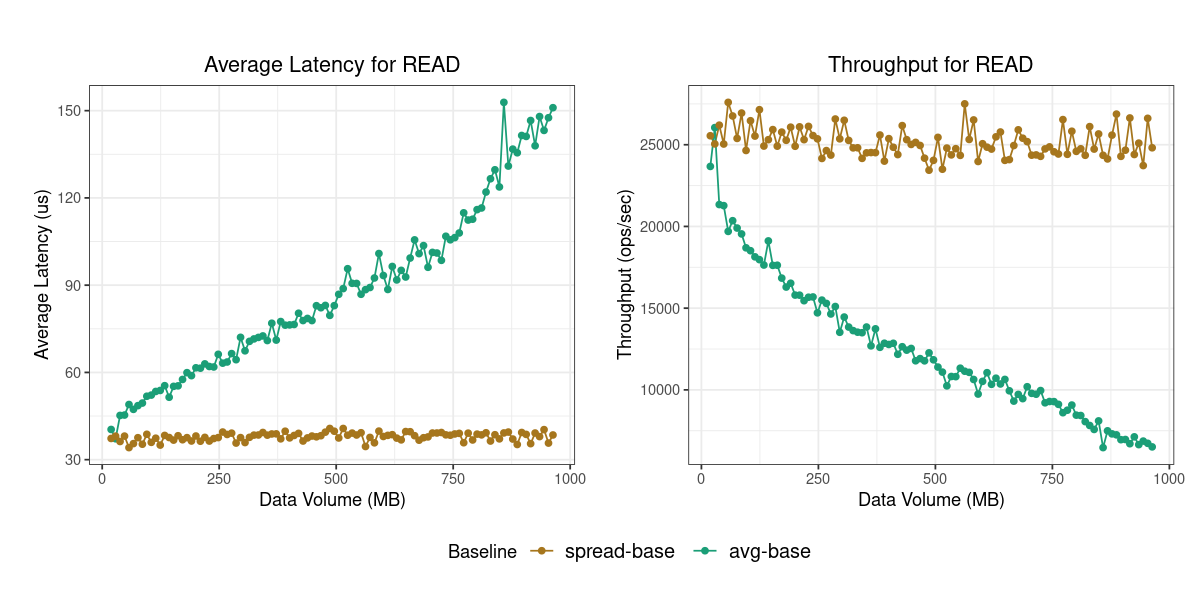

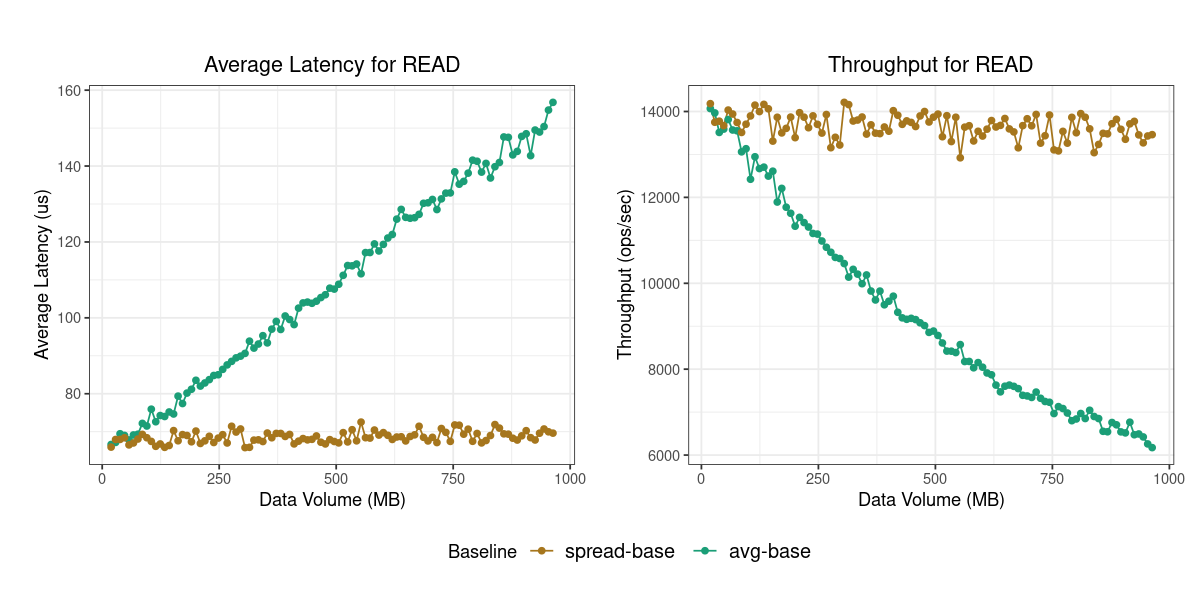

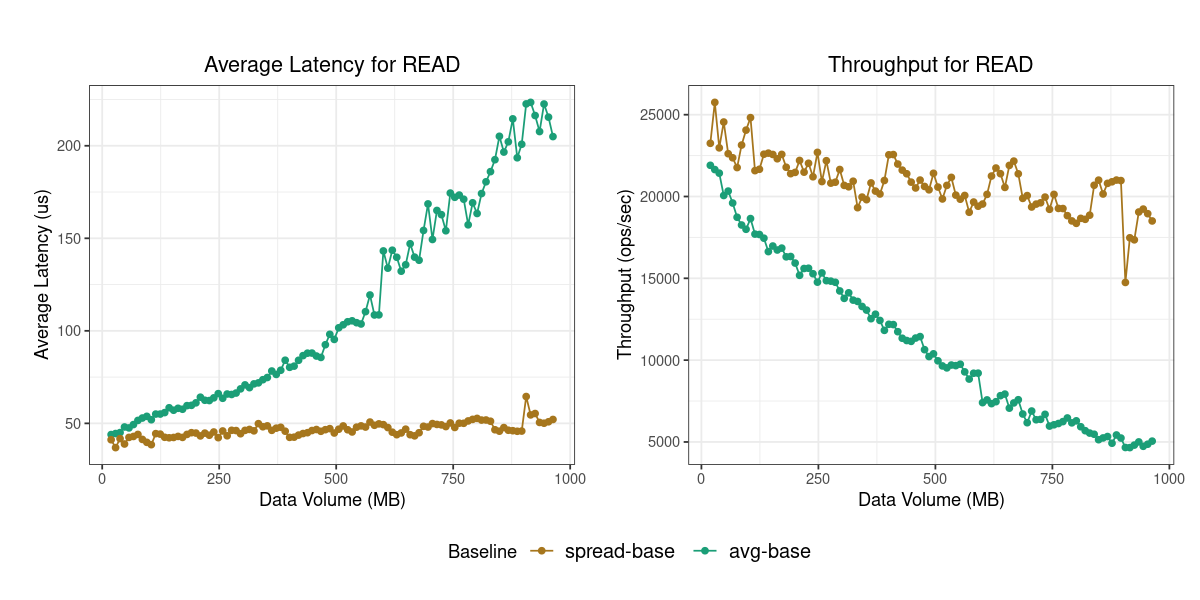

In [11]:
# Update dist array as we only use the data related to Uniform request distribution
dist = "uniform"
runs = c("run1")

# Specify the field length and the number of fields that YCSB-IVS uses
fieldlength = 100
nfields = 10

# Gather all the data of spead base runs into a single data frame
data_baseline = tibble()
for(run in runs){
  for(db in databases){
    for(weight in loads){
      dataset = paste(db,"_",run,"_","spreadrun","_",weight,".csv",sep="")
      temp = read.csv(dataset)
      database = sub(".*_(*)", "\\1", db)
      temp$database = database
      temp$load = weight
      temp$run = run
      temp$dist = dist
      temp = temp %>% select(variables_to_keep,
                              database,load,run,dist)
      data_baseline = rbind(data_baseline,temp)
    }
  }
}

# Combine data sets for baseline and avg-base
data = rbind(data_avg_run,data_baseline)

data = data %>% 
  mutate(load = ifelse(load == "heavy", "Heavyweight", "Lightweight")) %>%
  mutate(database = ifelse(database == "innodb", "InnoDB", 
                           ifelse(database == "rocksdb", "RocksDB",
                                  ifelse(database == "mongodb", "MongoDB", database)))) %>%
  mutate(volume = ifelse(Phase == "spread-run",
                         (Recordcount * nfields * fieldlength)/(1024*1024),
                         (Recordcount*(1+Epoch) * nfields * fieldlength)/(1024*1024))) %>%
  mutate(Phase = ifelse(Phase == "avg-run", "avg-base",
                        ifelse(Phase == "spread-run", "spread-base",Phase)))

# Summarise required variables using mean
data = data %>%
  group_by(load,database,Phase,Epoch) %>%
  summarize(across(where(is.numeric), mean, .names = "{.col}"), .groups = "drop")

data$Phase = factor(data$Phase, levels = c("spread-base", "avg-base"))

# Get unique database values
unique_databases = unique(data$database)

# Loop through each unique database value
for (db in unique_databases) {
  # Filter data for the current database and for Heavyweight workload
  db_data = subset(data, database == db)
  db_data = db_data %>% filter(load == "Heavyweight")

  # Generate the plots for the current database
  throughput_plot = ggplot(data = db_data, aes(x = volume)) +
    geom_line(aes(y = Throughput.ops.sec., color = Phase)) +
    geom_point(aes(y = Throughput.ops.sec., color = Phase)) +
    scale_x_continuous(
      name = "Data Volume (MB)"
    ) +
    scale_y_continuous(
      name = "Throughput (ops/sec)"
    ) +
    labs(
      x = "Data Volume (MB)",
      title = "Throughput for READ"
    ) +
    scale_color_manual(values = c("#A6761D", "#1B9E77"),
      name = "Baseline",
      labels = c("spread-base", "avg-base")) + # Display names for the legend)
    theme_bw() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 13),
      legend.position = "bottom",
      panel.spacing = unit(1, "lines"),  # Spacing between facets
      axis.title.y.right = element_text(margin = margin(l = 5)),  # Space for secondary y-axis
      strip.placement = "inside",  # Move facet labels inside the plot area
      strip.text.y.left = element_text(angle = 0, size = 10),  # Adjust row facet labels
      strip.text.x = element_text(size = 10),  # Adjust column facet labels
      plot.margin = margin(t = 10, r = 10, b = 10, l = 15),  # Increase plot margins
      legend.text = element_text(size = 12)
    )

  latency_plot = ggplot(data = db_data, aes(x = volume)) +
    geom_line(aes(y = AverageLatency.us. , color = Phase)) +
    geom_point(aes(y = AverageLatency.us., color = Phase)) +
    scale_x_continuous(
      name = "Data Volume (MB)"
    ) +
    scale_y_continuous(
      name = "Average Latency (us)",
    ) +
    labs(
      x = "Data Volume (MB)",

      title = "Average Latency for READ"
    ) +
    scale_color_manual(values = c("#A6761D", "#1B9E77"),
      name = "Baseline",
      labels = c("spread-base", "avg-base")) + # Display names for the legend)
    theme_bw() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 13),
      legend.position = "bottom",
      panel.spacing = unit(1, "lines"),  # Spacing between facets
      axis.title.y.right = element_text(margin = margin(l = 5)),  # Space for secondary y-axis
      strip.placement = "inside",  # Move facet labels inside the plot area
      strip.text.y.left = element_text(angle = 0, size = 10),  # Adjust row facet labels
      strip.text.x = element_text(size = 10),  # Adjust column facet labels
      plot.margin = margin(t = 10, r = 10, b = 10, l = 15),  # Increase plot margins
      legend.text = element_text(size = 12)
    )

  # Combine plots using patchwork
  combined_plot = (latency_plot | throughput_plot) +
    plot_layout(guides = "collect") + # Share and collect legends
    plot_annotation(title = "") &
    theme(legend.position = "bottom")

  # Show last plot
  options(repr.plot.width=10, repr.plot.height=5)
  print(combined_plot)

  # Set PDF device with specified width and height
  db = tolower(db)
  plot_file = paste(db,"_","baseline_performance",".pdf", sep = "")
  pdf(paste(analysis_directory, "/Figures/", db, "/", plot_file, sep = ""), width = 10, height = 5) 

  # Print the plot object
  print(combined_plot)

  # Turn off the PDF device
  dev.off()
}

### Change in Value Size Distributions as Workload Progresses

This section examines how value size distributions evolve during workload execution and their maximum value sizes for a selected database.

In [12]:
# Changing working directory
setwd(paste(analysis_directory, "/Data/Value_size_data", sep = ""))

pdf 
  2

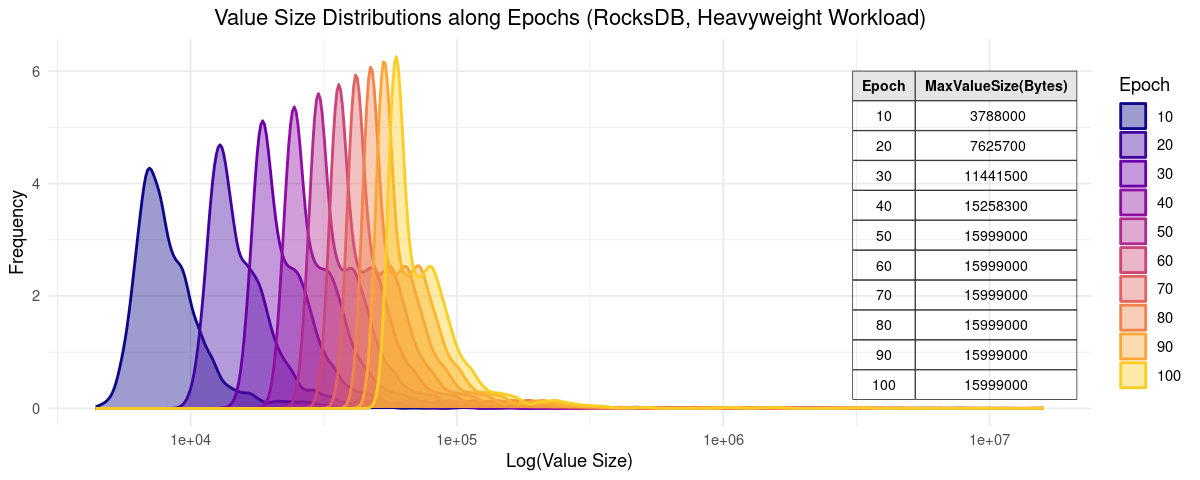

In [13]:
# Read output data
data = read.csv("value_sizes_rocksdb_run1_zipfian_heavy.csv")
colnames(data)[1] = "Key"
data = as.data.frame(data)

# Convert columns 2 onwards to character, then to numeric
data[, 2:ncol(data)] = lapply(data[, 2:ncol(data)], function(x) as.numeric(as.character(x)))

# Get the column names and extract Run numbers
column_names = colnames(data)
run_numbers = gsub("Run", "", column_names[-1])  # Extract numbers from "Run" column names

# Create a list to store the plots
plot_list = list()

# Create the required sequence of run columns
required_runs = seq(10, 100, by = 10)

# Pivot the data from wide to long format for easier plotting
long_data = data %>%
  select(1, all_of(required_runs + 1)) %>%  # Select the identifier column and required run columns
  pivot_longer(-1, names_to = "Run", values_to = "ValueSize")  # Reshape data to long format

# Extract the run number from the "Run" column
long_data = long_data %>%
  mutate(RunNumber = gsub("Run", "", Run))  # Remove "Run" from column names

# Reorder RunNumber so that 100 is the last level
long_data$RunNumber = fct_relevel(as.factor(long_data$RunNumber), "100", after = Inf)

max_values = long_data %>%
  group_by(RunNumber) %>%
  summarize(MaxValueSize = max(ValueSize)) %>%
  arrange(RunNumber) %>%
  rename(Epoch = RunNumber, "MaxValueSize(Bytes)" = MaxValueSize)

plt = ggplot(long_data, aes(x = ValueSize, group = RunNumber,
                      color = RunNumber, fill = RunNumber)) +
  geom_density(alpha = 0.4, size = 0.8) +
  scale_x_log10() + 
  scale_fill_viridis_d(option = "C", end = 0.9) +
  scale_color_viridis_d(option = "C", end = 0.9) +
  labs(title = "Value Size Distributions along Epochs (RocksDB, Heavyweight Workload)",
       x = "Log(Value Size)",
       y = "Frequency",
       color = "Epoch",
       fill = "Epoch") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "right")

# Create a tableGrob of max values
custom_theme = ttheme_minimal(
  core = list(bg_params = list(fill = NA, col = "black"),  # Add borders to table cells
              fg_params = list(fontsize = 8.5)),            # Font size for table cells
  colhead = list(bg_params = list(fill = "grey90", col = "black"),  # Grey shading with borders
                 fg_params = list(fontsize = 8.5, fontface = "bold"))  # Bold header text
)

table_grob = tableGrob(max_values, rows = NULL, theme = custom_theme)

# Place the table next to legend
plot_with_legend_and_table = ggdraw() +
  draw_plot(plt) +
  draw_grob(table_grob, x = 0.754, y = 0.41, width = 0.1, height = 0.2)

# Print the plot object
options(repr.plot.width=10, repr.plot.height=4)
plot_with_legend_and_table

# Save plot
# Set PDF device with specified width and height
pdf(paste(analysis_directory, "/Figures/rocksdb/rocksdb_value_size_dist_zipfian_heavy.pdf", sep = ""), width = 10, height = 4)

# Print the plot object
print(plot_with_legend_and_table)

# Turn off the PDF device
dev.off()